# Fixed point iterations

by [Richard Tsai](https://www.researchgate.net/profile/Richard_Tsai3)

$f:\mathbb{R}^d\mapsto\mathbb{R}^d$

* Need to come up with $g(x)$ such that 
$$ f(x^*)=0 \iff x^* = g(x^*) $$

* Introduce the fixed point iteration for $g$: $$ x_{k+1} := g(x_k).$$

**What should $g(x)$ be?** 
So that $x_k\longrightarrow x^*$



## Linear systems of equations
Let $$f(x)=Ax-b,$$
where $A$ is an $d\times d$ invertible matrix, and $x,b$ are two vectors in $\mathbb{R}^d$.
We want to find the solution of $f(x)=0$.

Typically, we write the above linear system of equations as 
$$ Ax =b $$

We will consider fixed point iterations with $g(x)=Gx+c$.

### General strategy for creating fixed-point iterations for systems by splitting the matrix

A general strategy in coming up with fixed point iterations is to *split* $A$ into the sum of two matrices, separate the equations accordingly by the equal sign
$$
A=M-N \implies Ax=b \iff Mx=Nx+b
$$
and define the iterations
$$
Mx^{(k+1)} = Nx^{(k)} +b, 
$$

leading to the general form

$$x^{(k+1)}=M^{-1}Nx^{(k)}+M^{-1}b \iff x^{(k+1)}=G x^{(k)}+ c $$

**Of course, $M$ has to be very simple and easy to invert.**

**Both iterative schemes can be used to solve *nonlinear* equations**

** Learniing objective **:
* Know how convergence of a fixed point iterations is related to the eigenvalues of the matrices involved


## Three fixed point iterations to solve linear systems of equations

We first discuss two particular fixed-point iterations (two different $g$'s):

* Jacobi iterations (J)
* Gauss-Seidel iterations (G-S)
* Successive Over Relaxations (SOR): this method builds on top of (G-S)

**Learning objectives**:

* Know how to write Julia code for the two methods
* Know the general convergence theory. 
    * For this class: Burden and Faires: Lemma 7.18, Theorem 7.19, Theorem 7.21


### Jacobi iterations

In the Jacobi iterations, $M=D$ is the diagonal of $A$ (and $N$ is $A$ with its diagonal culled out): $$G=G_J:=D^{-1}(L+U)$$ 

$$x^{(k+1)}=G_{J} x^{(k)}+ c_{J}$$

* **Very easy parallelization**


$$ 
a_{11} \mathbf{x_1^{(k+1)}} + a_{12} x_2^{(k)}+a_{13} x_3^{(k)}+...+a_{1n} x_n^{(k)}=b_1 
$$

$$ 
a_{21} x_1^{(k)} + a_{22} \mathbf{x_2^{(k+1)}}+a_{13} x_3^{(k)}+...+a_{1n} x_n^{(k)}=b_2 
$$

$$\vdots$$


Solving nonlinear equations: $ f_1(x) = 0,f_2(x)=0,...,f_n(x)=0, x=(x_1,x_2,...,x_n) $

$$ f_1(\mathbf{x_1^{(k+1)}}, x_2^{(k)}, ..., x_n^{(k)})=0 $$
$$ f_2({x_1^{(k)}}, \mathbf{x_2^{(k+1)}}, ..., x_n^{(k)})=0 $$
$$\vdots$$

In [1]:
#Example: Jacobi iterations

A=[10. 2. 3.; 4. 15. 6.; 7. 8. 19.]

#What happens if the diagonal elements are smaller, but A is still invertible?
#A=[1. 2. 3.; 4. 5. 6.; 7. 8. 19.]


M=zeros(3,3)

M=diagm( diag(A),0)

N=M-A

Minv = inv(M)

b=ones(3)
x=rand(3)

#the following for-loop is only for illustrating teh concept of Jacobi iteration
#in practice, one should never allocate memory for M or Minv
for k=1:25
   x = Minv*(N*x+b) 
   println(x)
end

println("\nChecking the residual: ", A*x-b)

[-0.161604, -0.293657, -0.049588]
[0.173608, 0.129596, 0.235815]
[0.00333625, -0.0739547, -0.0658961]
[0.13456, 0.0921354, 0.0825413]
[0.0568105, -0.00223245, -0.0357369]
[0.111168, 0.065812, 0.0326414]
[0.0770452, 0.0239654, -0.0160352]
[0.100017, 0.0525354, 0.0141558]
[0.0852462, 0.034333, -0.00633711]
[0.0950345, 0.0464692, 0.00676908]
[0.0886754, 0.0386165, -0.00194712]
[0.0928608, 0.0437987, 0.0037021]
[0.0901296, 0.0404229, -2.18793e-5]
[0.091922, 0.0426409, 0.00240575]
[0.0907501, 0.0411918, 0.000811544]
[0.0915182, 0.042142, 0.0018534]
[0.0910156, 0.0415205, 0.00117035]
[0.0913448, 0.0419277, 0.00161722]
[0.0911293, 0.0416612, 0.00132446]
[0.0912704, 0.0418357, 0.00151609]
[0.091178, 0.0417215, 0.00139058]
[0.0912385, 0.0417963, 0.00147275]
[0.0911989, 0.0417473, 0.00141894]
[0.0912249, 0.0417794, 0.00145417]
[0.0912079, 0.0417584, 0.0014311]

Checking the residual: [-0.000111221, -0.00020635, -0.000286973]


In [2]:
println("The eigenvalues of Minv*N is important. ")
eigvals(Minv*N)

The eigenvalues of Minv*N is important. 


3-element Array{Float64,1}:
 -0.65478 
  0.223815
  0.430965

In [3]:
#a more appropirate way to implementing the JAcobi iterations
function JacobiIterations!(x, A, b, numitrs)
   
   xnext=copy(x)
   sum=0.0
    
   for itr=1:numitrs 
   for i=1:size(A,1)
        sum=0.0
        for j in [1:i-1; i+1:size(A,2)]
            sum+=A[i,j]*x[j]
        end
        xnext[i] = (b[i]-sum)/A[i,i]
   end
    
   x.=xnext
   #println(itr,": ", x)
   end 
end


function JacobiIterations!(x, A, b, tol; max_itrs=100000)
   
   xnext=rand(size(x))
   sum=0.0

   itr=0
    
   while norm(xnext-x)>tol && itr<max_itrs
        x.=xnext
        
    for i=1:size(A,1)
        sum=0.0
        for j in [1:i-1; i+1:size(A,2)]
            sum+=A[i,j]*x[j]
        end
        xnext[i] = (b[i]-sum)/A[i,i]
    end
   itr+=1
   end 
    
   println("Jacobi finishes in ",itr," iterations.")

end

JacobiIterations! (generic function with 1 method)

In [4]:
x=rand(3)

JacobiIterations!(x, A, b, 25)

println(x)
println(A*x-b)

Jacobi finishes in 0 iterations.
[0.0306215, 0.98599, 0.363916]
[2.36994, 16.0958, 14.0167]


### Gauss-Seidel iterations

In the Gauss-Seidel iterations, $M$ is the lower triangular part of $A$ (including the diagonal)

$$ A= D-L-U, M=D-L, N=U \implies G_{GS}:=(D-L)^{-1}U$$

$$x^{(k+1)}=G_{GS} x^{(k)}+ c_{GS}$$

* This algorithm is of **sequential nature**:
    * Solve for first variable, $x_1$ in the first equation, using the previous guess for all other variables    
$$ 
a_{11} \mathbf{x_1} + a_{12} x_2^{(k)}+a_{13} x_3^{(k)}+...+a_{1n} x_n^{(k)}=b_1 
$$
    Obtain the value of $\mathbf{x_1^{(k+1)}}$.
    
    * Solve for the second variable, $x_2$, in the second equation, using the value $\mathbf{x_1^{(k+1)}}$, and the previous guess for all other variables
$$ 
a_{21} \mathbf{x_1^{(k+1)}} + a_{22} \mathbf{x_2}+a_{13} x_3^{(k)}+...+a_{1n} x_n^{(k)}=b_2 
$$
    Obtain the value of $\mathbf{x_2^{(k+1)}}$.
$$ \vdots$$

Solving nonlinear equations: $ f_1(x) = 0,f_2(x)=0,...,f_n(x)=0, x=(x_1,x_2,...,x_n) $

$$ f_1(\mathbf{x_1^{(k+1)}}, x_2^{(k)}, ..., x_n^{(k)})=0 $$
$$ f_2(\mathbf{x_1^{(k+1)}}, \mathbf{x_2^{(k+1)}}, ..., x_n^{(k)})=0 $$
$$\vdots$$

In [5]:
function GaussSeidelIterations!(x, A, b, tol; max_itrs=100000)
   
   sum=0.0
   itr=0
   xold=rand(size(x))
    
   while norm(xold-x)>tol && itr<max_itrs #for itr=1:numitrs 
    xold.=x
    for i=1:size(A,1)
        sum=0.0
            for j in [1:i-1; i+1:size(A,2)]
            sum+=A[i,j]*x[j]
        end
        x[i] = (b[i]-sum)/A[i,i]
    end
    itr+=1
   end
   
   println("Gauss-Seidel finishes in ",itr," iterations.")
end

GaussSeidelIterations! (generic function with 1 method)

### Gauss-Seidel is faster than Jacobi

In [6]:
x0=rand(3)

x=copy(x0)
GaussSeidelIterations!(x, A, b, 0.000001)

println(x)
println(A*x-b,"\n")

x=copy(x0)
JacobiIterations!(x, A, b, 0.000001)

println(x)
println(A*x-b)


Gauss-Seidel finishes in 10 iterations.
[0.0912146, 0.0417667, 0.00144021]
[-1.38889e-7, 6.43824e-7, 0.0]

Jacobi finishes in 36 iterations.
[0.0912144, 0.0417664, 0.00143994]
[-3.51563e-6, -6.52255e-6, -9.07119e-6]


## Successive over relaxation (SOR)

SOR is obtained by *averaging* the Gauss-Seidel update, $x^{(k+1)}_{GS}$, with the approximation computed in the previous iteration, $x^{(k)}$:

$$ x^{(k+1)}_{SOR}:= \omega x^{(k+1)}_{GS}+(1-\omega) x^{(k)}. $$


Three important theorems about SOR:

Theorem (Kahan): Let $a_{ii}\neq 0, i=1,2,\cdots,n$. **If SOR converges, then $0<\omega<2$.**

Theorem (Ostrowski-Reich): **SOR converges for all $0<\omega<2$ iff $A$ is invertible, symmetric, positive definite.**

**Choose $\omega$ to make $\rho(G_{SOR})$ as small as possible.**

* This was pioneered by David Young, here at UT Ausitn in 1950'

Theorem (Young): $\omega_{opt}$ as a function of $\rho(G_J)$.

For more in-depth exposition about the choice of $\omega$, check out GGK, Sec 11.3.4.

## Symmetric Successive over relaxation (SSOR)

Involves two SOR updates:

* One SOR step in which the G-S update involves solving each row of the linear system in **increasing order** (row 1, than row 2,..., row n). 
    * In other words, the G-S iteration is defined by $A=D-L-U=M-N$, with $M=D-L$.

* One SOR step in which the G-S update involves solving each row of the linear system in **decreasing order** (row n, than row (n-1),..., row 1).
    * In other words, the G-S iteration is defined by $A=D-L-U=M-N$, with $M=D-U$.

In [7]:
function SOR!(x, A, b, ω, tol; max_itrs=100000)
   
   sum=0.0
   itr=0
   xold=rand(size(x))
    
   diff=xold-x
    
   while norm(diff)>tol && itr<max_itrs 
    xold.=x
    for i=1:size(A,1)
        sum=0.0
        for j=1:i-1 
            sum+=A[i,j]*x[j]
        end
        for j=i+1:size(A,2) 
            sum+=A[i,j]*x[j]
        end

        x[i] = ω*(b[i]-sum)/A[i,i]+(1.0-ω)*xold[i]
    end
    diff.=xold.-x
    itr+=1
   end
   
   println("SOR finishes in ",itr," iterations.")
end

SOR! (generic function with 1 method)

In [8]:
#Example: Jacobi iterations

A=[6. 2. 3.; 4. 11. 6.; 7. 8. 14.]


M=zeros(3,3)

M=diagm( diag(A),0)

N=M-A

Minv = inv(M)

tol=1e-12

b=ones(3)
x=rand(3)

x0=rand(3)

x=copy(x0)
GaussSeidelIterations!(x, A, b, tol)

println(x)
println(A*x-b,"\n")

x=copy(x0)
JacobiIterations!(x, A, b, tol)

println(x)
println(A*x-b,"\n")

#SOR with non-optimal weight
x=copy(x0)
@time SOR!(x, A, b, 0.75, tol)

println(x)
println(A*x-b,"\n")

Gauss-Seidel finishes in 24 iterations.
[0.171247, 0.0528541, -0.0443975]
[-7.40741e-13, -2.06857e-12, 0.0]

Jacobi finishes in 485 iterations.
[0.171247, 0.0528541, -0.0443975]
[3.15925e-12, 6.17173e-12, 8.66729e-12]

SOR finishes in 50 iterations.
  0.101188 seconds (36.02 k allocations: 1.548 MiB)
[0.171247, 0.0528541, -0.0443975]
[-9.62452e-13, -6.09579e-12, 2.88547e-12]



### Example: solving a two-point boundary value problem for Poisson's equation

$$ -u_{xx} =f(x),~~~0<x<1,~~~u(0)=u(1)=0 $$

* Discretize the unit interval: $x_j = j\Delta x, j=0,1,2,\cdots,N,\Delta x =1/N$

* Approximate the differential equation on the grid nodes:
    $$ -u_{xx} (x_j)=f(x_j) \approx -(u_{j+1}-2u_j+u_{j-1})/\Delta x^2 = f(x_j),~~~j=1,2,\cdots,N-1 $$

* Set the boundary conditions: $u_0=0=u_N$.

This leads to a linear system to solve: $AU=F$.

In [9]:
N=50
xgrid=linspace(0,1,N+1)
Δx=1/N

f=x-> 1.0 #x.^2+0.0*sin(20*x)

#The vector U stores (u1,u2,u3,cdots, u_(N-1))
U=zeros(N-1)

#N-2 because we exclude x=0 and X=1.
A=spdiagm( (-ones(N-2), 2.0*ones(N-1),-ones(N-2)), [-1,0,1])
#A=-2.*diagm(ones(N-1))+diagm(ones(N-2),1)+diagm(ones(N-2),-1)
F=collect(f.(xgrid[2:end-1]))

b=F.*Δx^2

@time U=-A\b

Ugs=copy(U)
Uj=copy(U)
Usor=copy(U)

println("\n")
@time GaussSeidelIterations!(Ugs, A, b, 1e-10)

println("\n")
@time JacobiIterations!(Uj, A, b, 1e-10)

println("\n")
@time SOR!(Usor, A, b, 1.5, 1e-10)

M=diagm(diag(A),0)
N=M-A
λ=svdvals(M\N)
ωopt=2.0/(1.0+sqrt(1.0-λ[1]^2))

println("λ_J = ", λ[1],"\n")
println("optimal ω for this case is ", ωopt,"\n")
Usor=copy(U)
@time SOR!(Usor, A, b, ωopt-0.2, tol)

  0.682930 seconds (257.98 k allocations: 13.603 MiB, 0.87% gc time)


Gauss-Seidel finishes in 4494 iterations.
  0.210010 seconds (683.78 k allocations: 131.004 MiB, 6.99% gc time)


Jacobi finishes in 11250 iterations.
  0.405807 seconds (1.68 M allocations: 326.109 MiB, 3.64% gc time)


SOR finishes in 1580 iterations.
  0.125506 seconds (26.05 k allocations: 1.146 MiB)
λ_J = 0.9980267284282716

optimal ω for this case is 1.8818383898322273

SOR finishes in 1123 iterations.
  0.032533 seconds (61 allocations: 2.938 KiB)


INFO: Recompiling stale cache file /Users/ytsai/.julia/lib/v0.6/PyPlot.ji for module PyPlot.


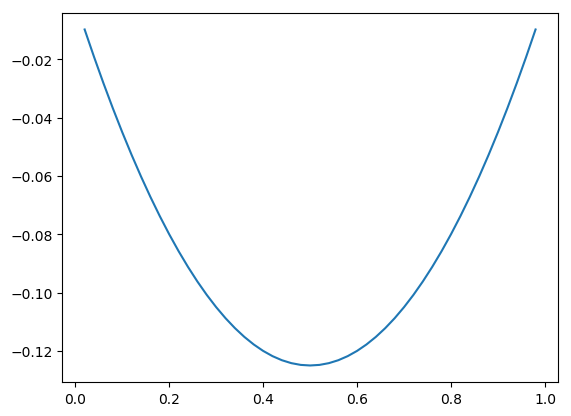

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x12d5c83d0>

In [10]:
using PyPlot

plot(xgrid[2:end-1], U)

### Poisson equation in three dimensions

$$-(u_{xx}+u_{yy}+u_{zz})=f(x,y,z),~~~0<x,y,z<1$$

with zero Dirichlet boundary conditions.

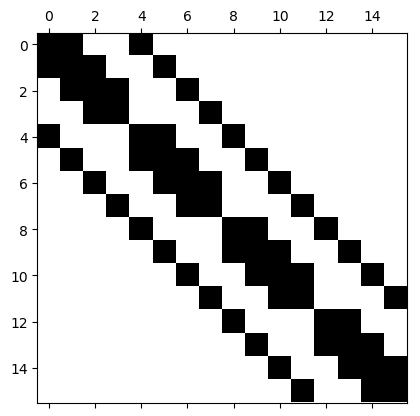

PyObject <matplotlib.image.AxesImage object at 0x13a272090>

In [49]:
N=5
xgrid=linspace(0,1,N+1)
Δx=1/N

#assemling the finite different operator for the left hand side of the PDE
T=spdiagm( (-ones(N-2), 2.0*ones(N-1),-ones(N-2)), [-1,0,1])
I=speye(N-1,N-1)

A=kron(T,I)+kron(I,T)

using PyPlot
spy(A)

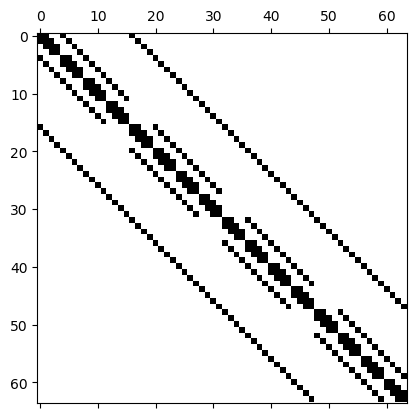

PyObject <matplotlib.image.AxesImage object at 0x136ba9390>

In [46]:
A=kron(kron(T,I),I)+ kron(I,kron(I,T))+ kron(kron(I,T),I)

size(A)

using PyPlot
spy(A)

In [ ]:
N=100
xgrid=linspace(0,1,N+1)
Δx=1/N

f=(x,y)-> x.^2+y+z.^2

#assemling the finite different operator for the left hand side of the PDE
T=spdiagm( (-ones(N-2), 2.0*ones(N-1),-ones(N-2)), [-1,0,1])
I=speye(N-1,N-1)

#discretize the Laplace operator in 2D
#A=kron(T,I)+kron(I,T)

#discretize the Laplace operator in 3D
A=kron(kron(T,I),I)+ kron(I,kron(I,T))+ kron(kron(I,T),I)

F=ones(size(A,1))

b=F.*Δx^2

U=copy(F)
Uj=copy(F)
Ugs=copy(F)
Usor=copy(F)

println("size of the matrix:", size(A))

println("Optimal direct solver: ")
@time U=A\b

#println("LU:")
#F=lufact(A)
#@time U=inv(F[:U])*inv(F[:L])*b

println("\n")
#@time GaussSeidelIterations!(Ugs, A, b, 1e-12)

println("\n")
#@time JacobiIterations!(Uj, A, b, 1e-12)

println("\n")
#@time SOR!(Usor, A, b, 1.5, 1e-12)

## Convergence of iterative algorithms

* linearly convergent algorithms: (**the error in the next step is a linear function of the current error**)
$$ e_{n+1} = a e_n $$
    
    * number of correct digits is a linear function of the number of iterations: $$ \textrm{num of accurate digits} = \alpha_0 n $$


* quadratically convergent algorithms: (**the error in the next step is a quadratic function of the current error**)
$$ e_{n+1} = a e_n^2 $$

    * number of correct digits doubles after each iterations: $$ \textrm{num of accurate digits} = \alpha_1 2^n$$


* p-th order convergent algorithms:
$$ e_{n+1} = a e_n^p $$

### Possible confusion with ***order of accuracy***

(For linearly convergent algorithms)
$$e_n \le Const\cdot \frac{1}{n^p}$$

**p-th order accurate algorithm**.

## The conjugate gradient (CG) method of Hestenes and Stiefel (1952)

$$Ax=b$$
* It is optimal for symmetric positive definite systems: $A^T =A,~~~x^TAx>0,~\forall x\neq 0$
* It is a type of **Krylov methods**
* In each iteration, say iteration $k$, the algorithm chooses the next guess, $x^{(k+1)}$, by 
  * minimizes the residual, $r^{(k+1)}:=b-Ax^{(k+1)}$, 
  * in a special norm built from $A$ and $x^{(j)},j=1,2,\cdots,k$.
* Very simple, elegant and fast algorithm.

* We have seen that solving teh model Poisson's problem in 1 and 2 dimenions, the backlash operator is faster than CG. But the situation changes when we solve the Poisson's equation in 3D, for which the matrix has more strides away from teh diagonal.

* See Algorithm 11.15 in GGK or this workbook (instead of BF) for a more comprehensive view of teh CG algorithm.

**Learning objectives**:

* Know when CG is applicable
* Theorem 7.31 in Burden and Faires: Under which conditions will solving the given linear system be equivalent to solving a related minimization problem.
    * This theorem provides a hint to the "G" in CG.
    * Know how to formula the method of steepest descent for the minimization problem
* Theorem 7.32
* Have some idea how Theorems 7.31-7.32 are related to CG.

In [33]:
CG(A,b;kwargs...) = CG(x -> A*x,b;kwargs...)
    
function CG(A::Function, b; tol=1e-2, maxItr=1000)

    n = length(b)

    #initial guess
    x=zeros(n)
    
    #initial residual
    r=b-A(x)

    p = copy(r)
    
    res0  = norm(r)

    itr   = 1 
    
    for itr=1:maxItr
        Ap = A(p)
        pAp= dot(p,Ap)
        α  = dot(r,p)/pAp

        #update the approximate solution
        x.+=α.*p
        
        #update the residual vector
        r.-=α.*Ap
            
        #break the loop when tolerance is met
        if norm(r)/res0 <= tol
            break
        end

        #update search direction
        β = -dot(Ap,r)/pAp           
        p.=r.+β.*p
    end

    println("cg termines after ", itr, " steps, with residual=", norm(r))
end

CG (generic function with 2 methods)

In [44]:
@time uu=CG(A,b, tol=1e-12)

cg termines after 308 steps, with residual=9.340764768530949e-14
  6.470190 seconds (812 allocations: 2.256 GiB, 3.95% gc time)


In [6]:
using KrylovMethods

In [43]:
@time uu=KrylovMethods.cg(A, b, tol=1e-14, maxIter=1500, out=1);

size(A)

cg achieved desired tolerance at iteration 371. Residual norm is 9.21e-15.
  5.533515 seconds (847 allocations: 29.640 MiB, 0.03% gc time)


(970299, 970299)

In [ ]:
using PyPlot

plot(uu[1])

In [1]:
J=diagm(0.1*ones(5))+diagm(ones(4),1)

5×5 Array{Float64,2}:
 0.1  1.0  0.0  0.0  0.0
 0.0  0.1  1.0  0.0  0.0
 0.0  0.0  0.1  1.0  0.0
 0.0  0.0  0.0  0.1  1.0
 0.0  0.0  0.0  0.0  0.1

In [7]:
J^2

5×5 Array{Float64,2}:
 0.01  0.2   1.0   0.0   0.0 
 0.0   0.01  0.2   1.0   0.0 
 0.0   0.0   0.01  0.2   1.0 
 0.0   0.0   0.0   0.01  0.2 
 0.0   0.0   0.0   0.0   0.01

In [8]:
J^3

5×5 Array{Float64,2}:
 0.001  0.03   0.3    1.0    0.0  
 0.0    0.001  0.03   0.3    1.0  
 0.0    0.0    0.001  0.03   0.3  
 0.0    0.0    0.0    0.001  0.03 
 0.0    0.0    0.0    0.0    0.001

In [4]:
J^4

5×5 Array{Float64,2}:
 0.0001  0.004   0.06    0.4     1.0   
 0.0     0.0001  0.004   0.06    0.4   
 0.0     0.0     0.0001  0.004   0.06  
 0.0     0.0     0.0     0.0001  0.004 
 0.0     0.0     0.0     0.0     0.0001